In [1]:
pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import eda_helper_functions

from sklearn.ensemble import IsolationForest

## 2. Read the training data 

The process of EDA and feature engineering will always be done over the training dataset

#### 2.1 read the 'training' data subset

In [4]:
file_path = r"C:\Users\Dell\OneDrive\Desktop\flight-sagemaker-project\data\train.csv"

train = pd.read_csv(file_path) 
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-03-06,Mumbai,Hyderabad,06:00:00,09:10:00,1630,2.0,No Info,13169
1,Multiple Carriers,2019-05-18,Delhi,Cochin,13:00:00,01:30:00,750,1.0,No Info,9385
2,Jet Airways,2019-03-21,Banglore,New Delhi,11:40:00,10:25:00,1365,1.0,In-flight meal not included,7832
3,Air India,2019-05-18,Kolkata,Banglore,12:00:00,18:30:00,1830,2.0,No Info,10361
4,Goair,2019-05-03,Banglore,Delhi,07:45:00,10:40:00,175,0.0,No Info,3898


- checked the data types

In [5]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

- Fixed datatypes(here, object to datetime)

In [6]:
## train.loc[:, col] = This selects all rows (:) and the column named col.

train = train.assign(**{
    col: pd.to_datetime(train.loc[:, col], dayfirst = True, format="mixed")
    for col in ["date_of_journey","dep_time", "arrival_time"]
})

train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   date_of_journey  640 non-null    datetime64[ns]
 2   source           640 non-null    object        
 3   destination      640 non-null    object        
 4   dep_time         640 non-null    datetime64[ns]
 5   arrival_time     640 non-null    datetime64[ns]
 6   duration         640 non-null    int64         
 7   total_stops      640 non-null    float64       
 8   additional_info  640 non-null    object        
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


In [8]:
train.isnull().sum()

airline            0
date_of_journey    0
source             0
destination        0
dep_time           0
arrival_time       0
duration           0
total_stops        0
additional_info    0
price              0
dtype: int64

In [9]:
train.describe(include = "number")

,duration,total_stops,price
count,640.000000,640.00000,640.0000
mean,641.796875,0.81250,9013.2500
std,504.859226,0.66608,4160.6207
min,75.000000,0.00000,1965.0000
25%,175.000000,0.00000,5405.2500
50%,515.000000,1.00000,8356.0000
75%,910.000000,1.00000,12373.0000
max,2295.000000,3.00000,27992.0000


In [10]:
train.describe(include="O")

,airline,source,destination,additional_info
count,640,640,640,640
unique,8,5,6,5
top,Jet Airways,Delhi,Cochin,No Info
freq,229,267,267,493


here we want to include the total stops column in object datatype 

In [11]:
(
    train
    .assign(total_stops=train["total_stops"].astype(object))
    .describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,640,640,640,640.0,640
unique,8,5,6,4.0,5
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,229,267,267,340.0,493


## 3. High-level analysis of missing values

In [12]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


- just for the sake of practice 

In [13]:
temp = pd.read_csv(r"C:\Users\Dell\OneDrive\Desktop\flight-sagemaker-project\data\titanic.csv")

In [14]:
eda_helper_functions.missing_info(temp)

,count,percentage
variable,,
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


In [15]:
temp.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [16]:
##
temp['Cabin'].isna().any()

True

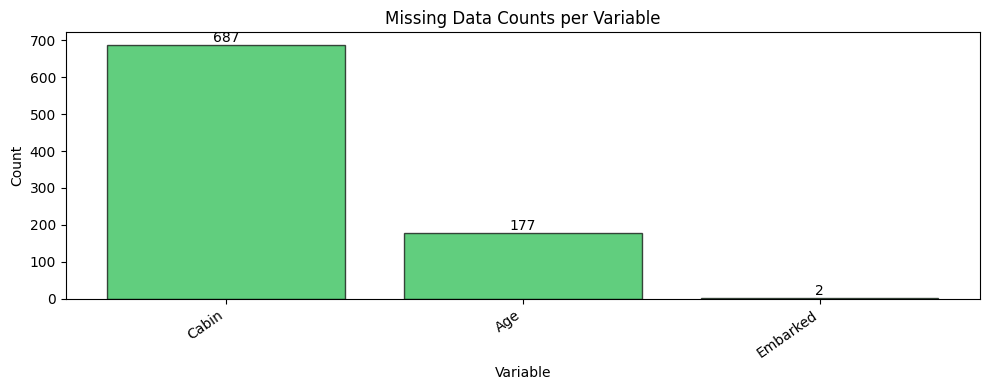

In [17]:
eda_helper_functions.plot_missing_info(temp)

### 4. High Level analysis for Outliers 

In [18]:
forest = IsolationForest(n_estimators=10,random_state=42)

In [19]:
(
    train
    .assign(outlier=forest.fit_predict(train
                                      .drop(columns="price")
                                      .select_dtypes(include="number")))
    .query("outlier == -1")
    #.duration
    #.describe()
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
0,Air India,2019-03-06,Mumbai,Hyderabad,2025-06-01 06:00:00,2025-06-01 09:10:00,1630,2.0,No Info,13169,-1
2,Jet Airways,2019-03-21,Banglore,New Delhi,2025-06-01 11:40:00,2025-06-01 10:25:00,1365,1.0,In-flight meal not included,7832,-1
3,Air India,2019-05-18,Kolkata,Banglore,2025-06-01 12:00:00,2025-06-01 18:30:00,1830,2.0,No Info,10361,-1
5,Air India,2019-05-27,Delhi,Cochin,2025-06-01 13:15:00,2025-06-01 09:25:00,1210,2.0,No Info,10467,-1
7,Air Asia,2019-05-27,Delhi,Cochin,2025-06-01 16:45:00,2025-06-01 22:25:00,340,1.0,No Info,6752,-1
...,...,...,...,...,...,...,...,...,...,...,...
633,Air India,2019-05-01,Kolkata,Banglore,2025-06-01 05:50:00,2025-06-01 20:25:00,875,2.0,No Info,10991,-1
634,Jet Airways,2019-06-15,Mumbai,Hyderabad,2025-06-01 10:20:00,2025-06-01 11:50:00,90,0.0,No Info,5678,-1
635,Indigo,2019-05-27,Chennai,Kolkata,2025-06-01 07:55:00,2025-06-01 10:15:00,140,0.0,No Info,3850,-1
636,Jet Airways,2019-06-27,Delhi,Cochin,2025-06-01 20:00:00,2025-06-01 04:25:00,505,2.0,No Info,16263,-1


## 5. Pair Plots

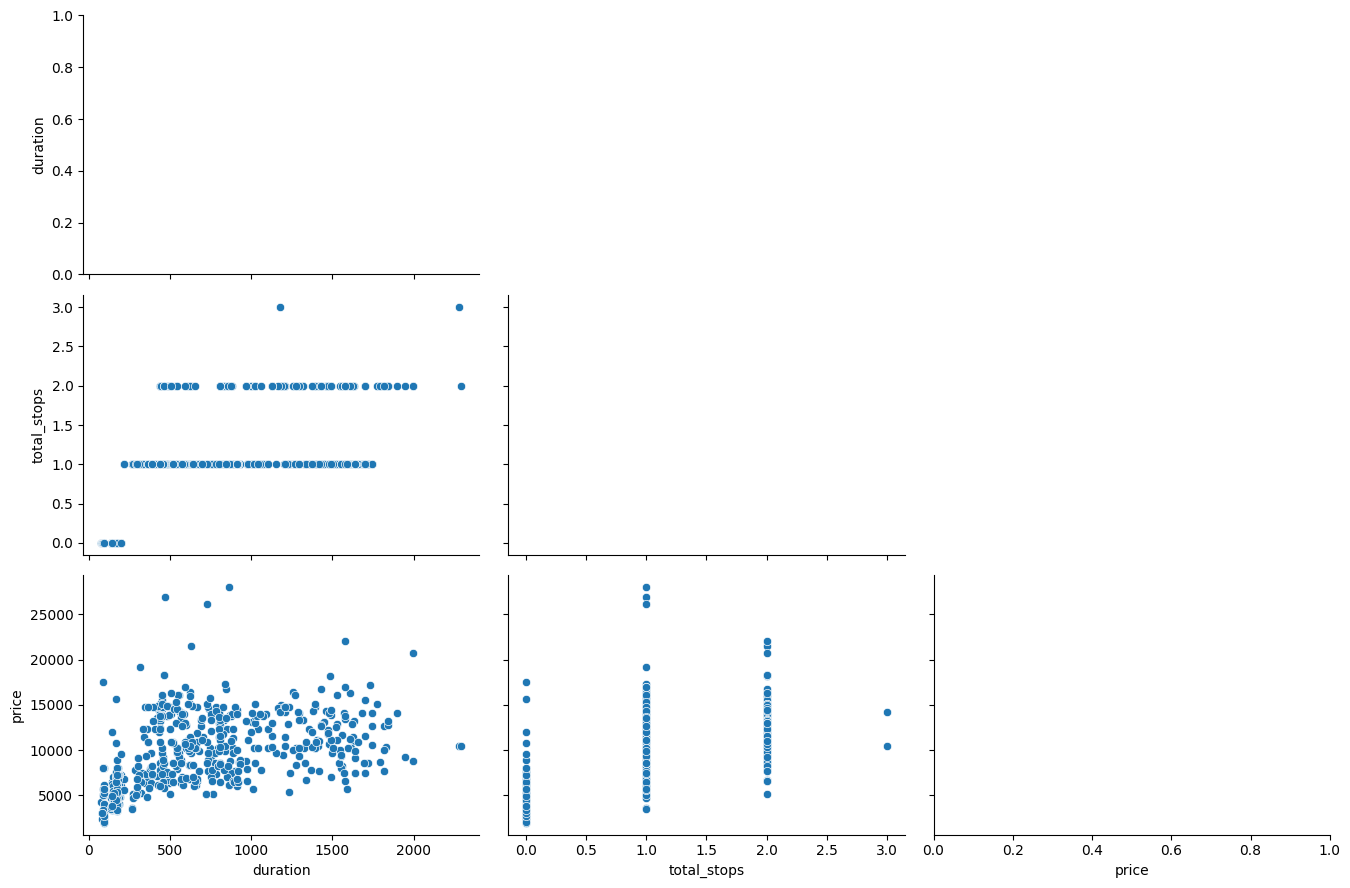

In [20]:
eda_helper_functions.pair_plots(train)

## 6. Correlation Analysis

#### Q) What is multicollinearity ??

Definition:
Multicollinearity happens when two or more features (inputs) in your dataset are highly correlated — meaning they give similar information to the model.

#### ⚠️ Why is Multicollinearity a Problem?
- It confuses the model:

The model can’t tell which feature is really affecting the target (output).
- It makes the model unstable:

Small changes in the data can lead to big changes in the model's predictions.
- It reduces model interpretability:

You won’t know which features are actually important.

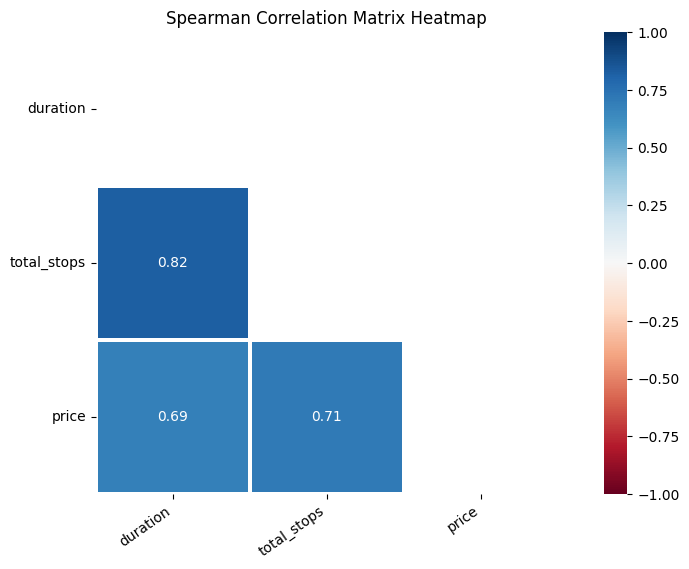

In [21]:
eda_helper_functions.correlation_heatmap(train)

In [22]:
train.corr(method="spearman", numeric_only=True)

,duration,total_stops,price
duration,1.000000,0.821933,0.686601
total_stops,0.821933,1.000000,0.708434
price,0.686601,0.708434,1.000000


 ### 7. Detailed Analysis

In [23]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   date_of_journey  640 non-null    datetime64[ns]
 2   source           640 non-null    object        
 3   destination      640 non-null    object        
 4   dep_time         640 non-null    datetime64[ns]
 5   arrival_time     640 non-null    datetime64[ns]
 6   duration         640 non-null    int64         
 7   total_stops      640 non-null    float64       
 8   additional_info  640 non-null    object        
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


#### 8.1 airline

In [25]:
train['airline']

0              Air India
1      Multiple Carriers
2            Jet Airways
3              Air India
4                  Goair
             ...        
635               Indigo
636          Jet Airways
637          Jet Airways
638          Jet Airways
639          Jet Airways
Name: airline, Length: 640, dtype: object

In [26]:
eda_helper_functions.cat_summary(train, 'airline')

0              Air India
1      Multiple Carriers
2            Jet Airways
3              Air India
4                  Goair
             ...        
635               Indigo
636          Jet Airways
637          Jet Airways
638          Jet Airways
639          Jet Airways
Name: airline, Length: 640, dtype: object

Data Type      : object
Cardinality    : 8 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,8
top,Jet Airways
freq,229


,count,percentage
category,,
Jet Airways,229,0.357812
Air India,116,0.181250
Indigo,111,0.173437
Multiple Carriers,81,0.126562
Spicejet,42,0.065625
Vistara,27,0.042188
Air Asia,24,0.037500
Goair,10,0.015625


In [27]:
train['airline'].value_counts()

airline
Jet Airways          229
Air India            116
Indigo               111
Multiple Carriers     81
Spicejet              42
Vistara               27
Air Asia              24
Goair                 10
Name: count, dtype: int64

In [28]:
train.shape

(640, 10)

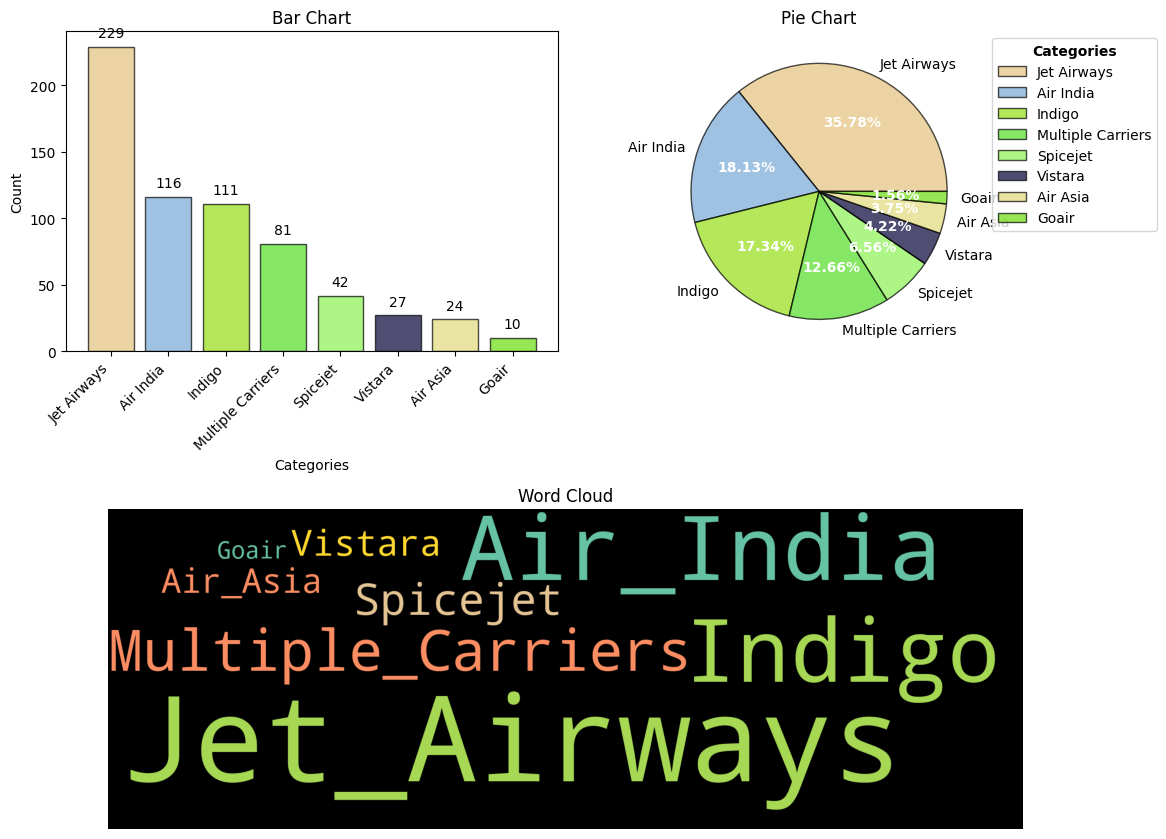

In [29]:
eda_helper_functions.cat_univar_plots(train,"airline")

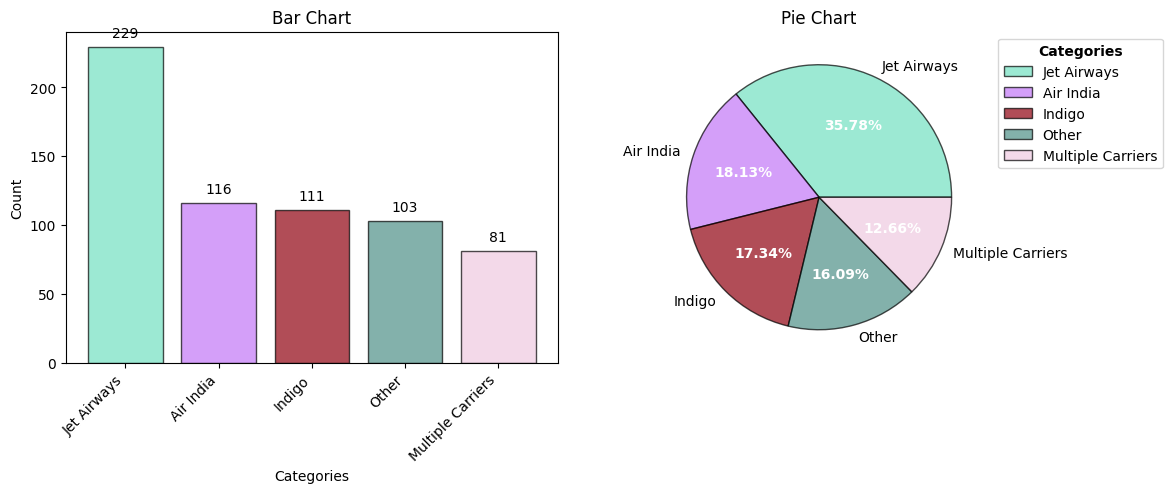

In [30]:
eda_helper_functions.cat_univar_plots(train, "airline", show_wordcloud=False, k=4)

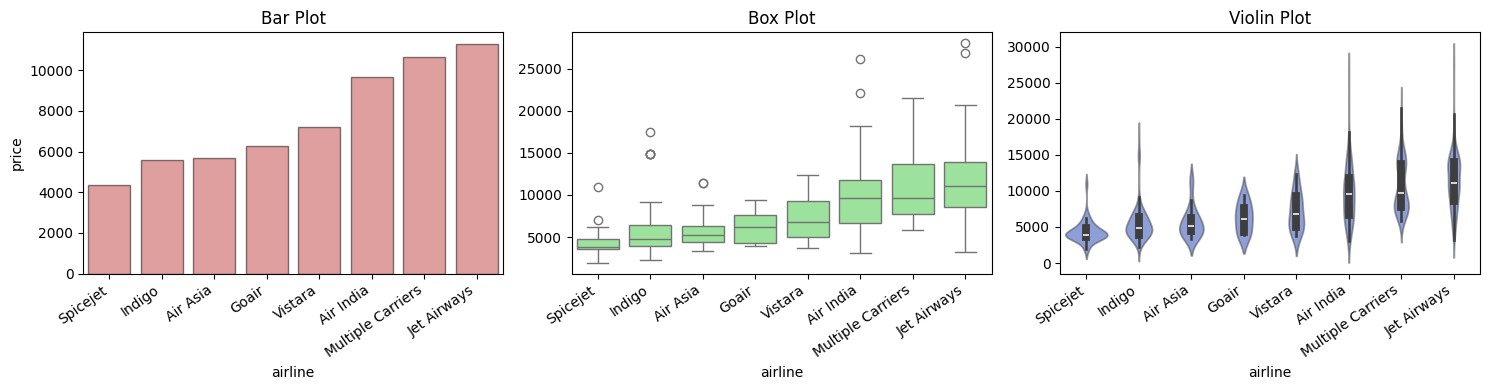

In [31]:
eda_helper_functions.num_cat_bivar_plots(
    data = train,
    num_var="price",
    cat_var="airline"
)

### Multivariate analysis

In [32]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 53.9686362717179
- p-value              : 2.3055851756461988e-60
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 282.92267089936325
- p-value              : 2.6719550359862743e-57
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


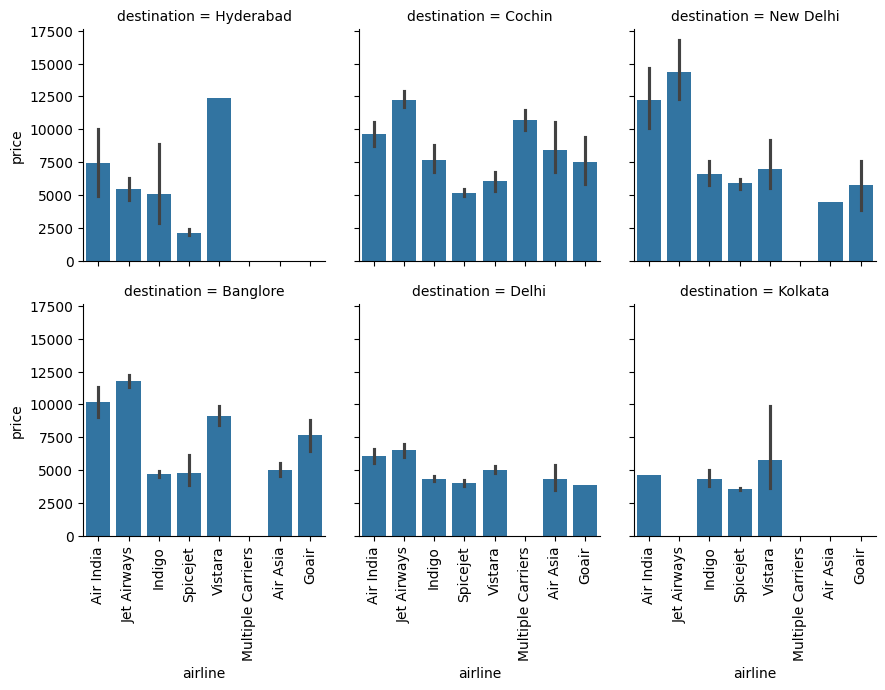

In [33]:
airline_grid = sns.FacetGrid(
    data = train,
    col="destination",
    col_wrap = 3,
    sharey=True
)

airline_grid.map(sns.barplot, "airline", "price")

for ax in airline_grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.show()


### 8.2 Date_Of_journey

In [34]:
train.date_of_journey

0     2019-03-06
1     2019-05-18
2     2019-03-21
3     2019-05-18
4     2019-05-03
         ...    
635   2019-05-27
636   2019-06-27
637   2019-06-12
638   2019-06-09
639   2019-05-09
Name: date_of_journey, Length: 640, dtype: datetime64[ns]

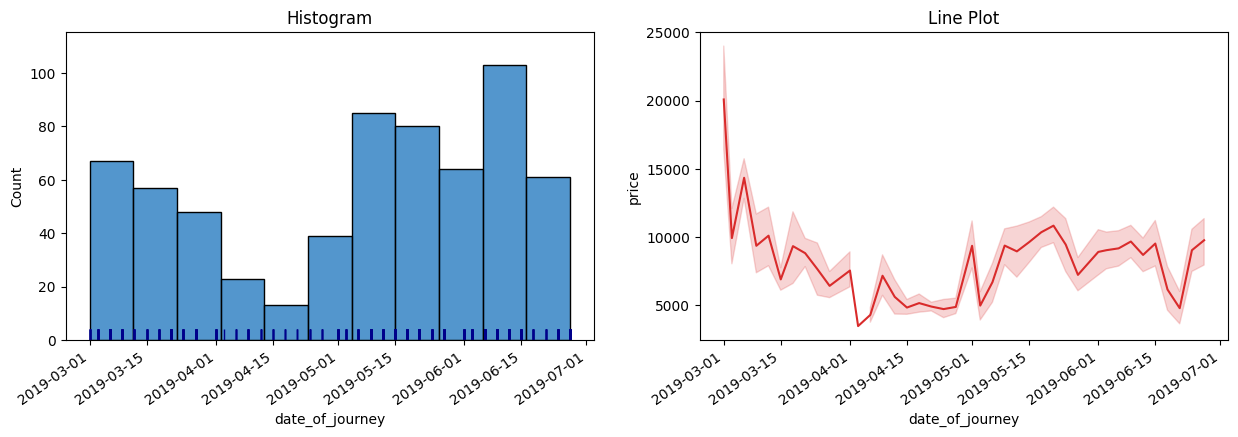

In [35]:
eda_helper_functions.dt_univar_plots(
    data=train,
    var="date_of_journey",
    target="price"
)

- Month wise univariate analysis

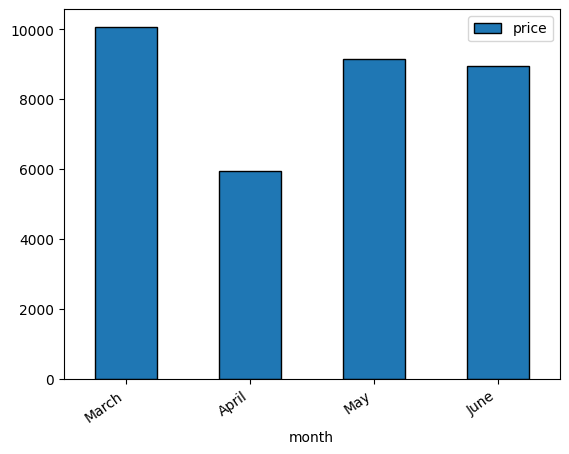

In [36]:
(
    train
    .groupby(pd.Grouper(key="date_of_journey", freq="M"))
    .price.mean()
    .to_frame()
    .set_axis(['March','April','May','June'],axis=0)# I want to rename my axis values . therefore, axis = 0
    .rename_axis(index="month")
    .plot(
        kind='bar',
        edgecolor='black'
    )
    
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

- From the above univariate analysis we can say that date of journey is also a good feature for for predicting flight prices

- Week wise univariate analysis 

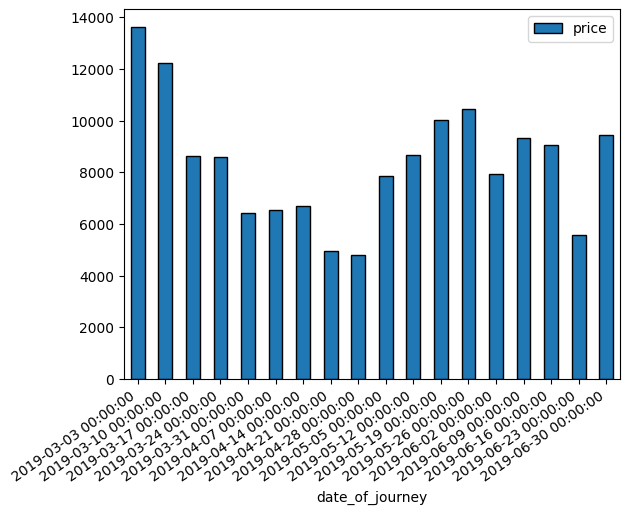

In [37]:
(
    train
    .groupby(pd.Grouper(key="date_of_journey", freq="w"))
    .price.mean()
    .to_frame()
    #.set_axis(['March','April','May','June'],axis=0)# I want to rename my axis values . therefore, axis = 0
    #.rename_axis(index="week")
    .plot(
        kind='bar',
        edgecolor='black'
    )
    
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

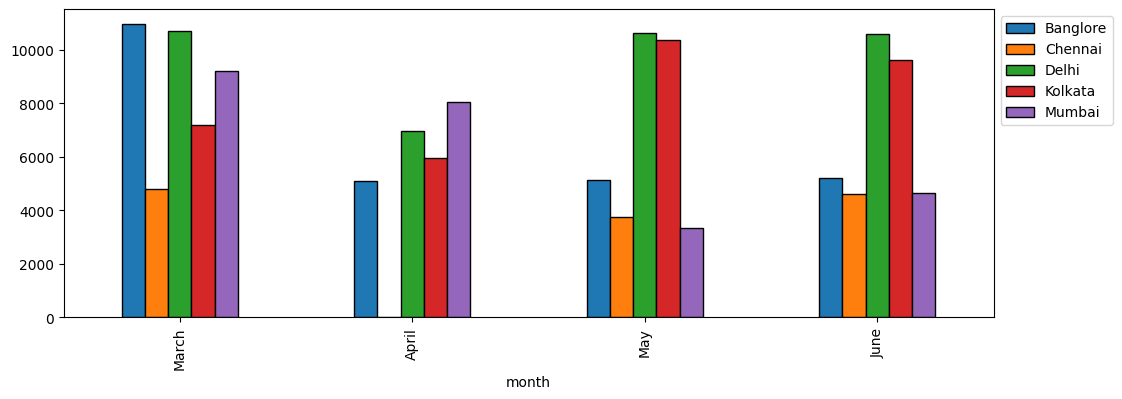

In [38]:
(
    train
    .groupby([pd.Grouper(key="date_of_journey", freq="M"), "source"])
    .price.mean()
    .unstack(fill_value=0)
    .set_axis(['March','April','May','June'],axis=0)# I want to rename my axis values . therefore, axis = 0
    .rename_axis(index="month")
    .plot(
        kind='bar',
        figsize=(12,4),
        edgecolor='black'
    )

)
ax = plt.gca()

ax.legend(
    loc="upper left",
    bbox_to_anchor=(1,1)
)

#### 8.3 dep_time

In [39]:
train.dep_time

0     2025-06-01 06:00:00
1     2025-06-01 13:00:00
2     2025-06-01 11:40:00
3     2025-06-01 12:00:00
4     2025-06-01 07:45:00
              ...        
635   2025-06-01 07:55:00
636   2025-06-01 20:00:00
637   2025-06-01 06:30:00
638   2025-06-01 11:00:00
639   2025-06-01 20:00:00
Name: dep_time, Length: 640, dtype: datetime64[ns]

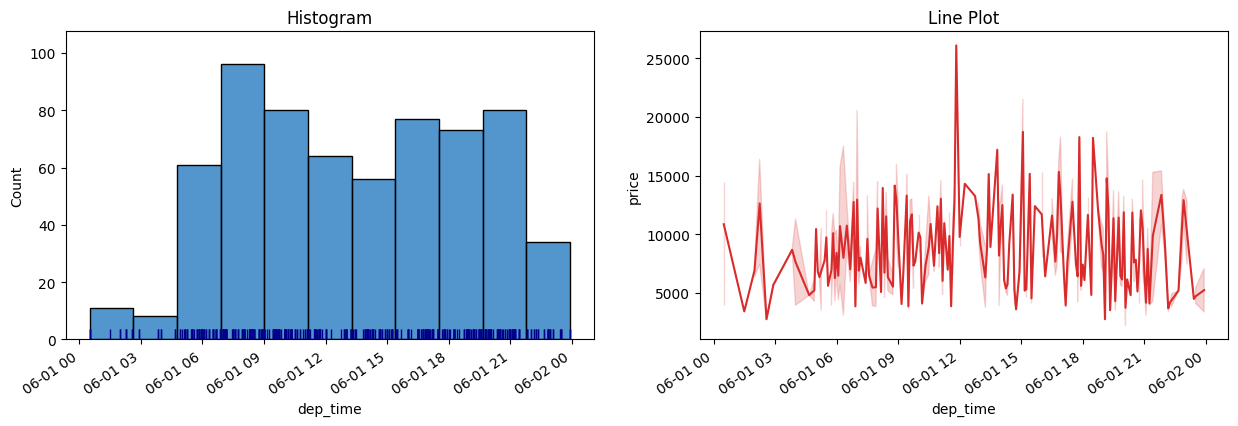

In [40]:
eda_helper_functions.dt_univar_plots(train, "dep_time", "price")

- convert or divide the hours into categories . such as morning, evening , day, night

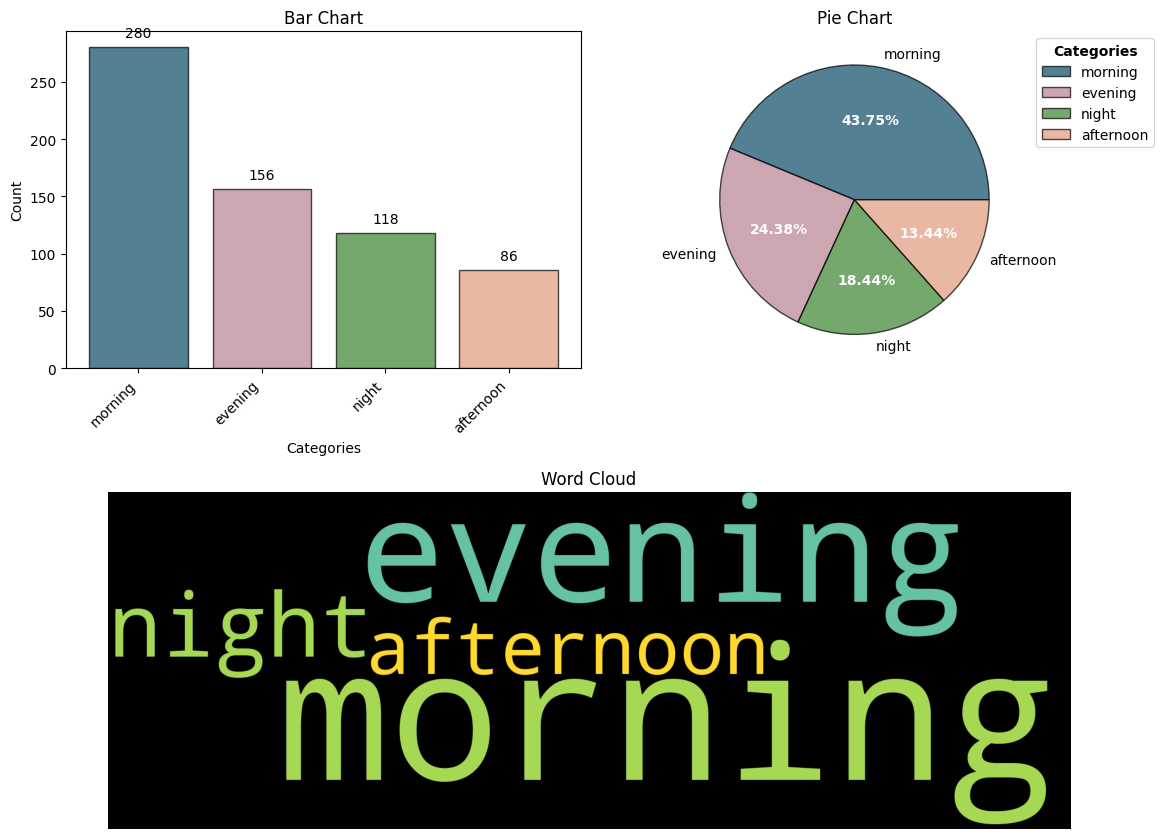

In [41]:
'''
(
    train
    .dep_time
    .dt.hour
    .pipe(lambda ser: pd.Series(np.select([ser.between(4, 12,inclusive="left"),
                                ser.between(12, 16, inclusive="left"),
                                ser.between(16, 20, inclusive="left")],
                                ["morning",
                                "afternoon",
                                "evening"],
                                default="night")))
)
'''
(
    train
    .assign(dep_time=lambda df_:(
        np.select([df_.dep_time.dt.hour.between(4, 12, inclusive="left"),
                  df_.dep_time.dt.hour.between(12,16, inclusive="left"),
                  df_.dep_time.dt.hour.between(16,20, inclusive="left")],
                 ["morning", "afternoon", "evening"],
                 default="night")
    ))
    .pipe(eda_helper_functions.cat_univar_plots, "dep_time")
)

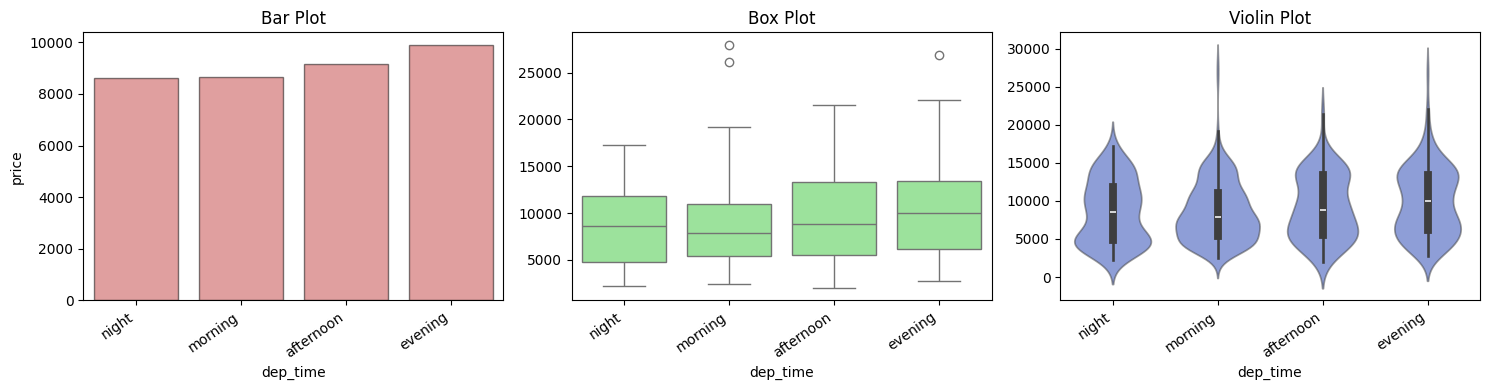

In [42]:
'''
(
    train
    .dep_time
    .dt.hour
    .pipe(lambda ser: pd.Series(np.select([ser.between(4, 12,inclusive="left"),
                                ser.between(12, 16, inclusive="left"),
                                ser.between(16, 20, inclusive="left")],
                                ["morning",
                                "afternoon",
                                "evening"],
                                default="night")))
)
'''
(
    train
    .assign(dep_time=lambda df_:(
        np.select([df_.dep_time.dt.hour.between(4, 12, inclusive="left"),
                  df_.dep_time.dt.hour.between(12,16, inclusive="left"),
                  df_.dep_time.dt.hour.between(16,20, inclusive="left")],
                 ["morning", "afternoon", "evening"],
                 default="night")
    ))
    .pipe(eda_helper_functions.num_cat_bivar_plots,"price", "dep_time")
)

### 8.4 duration

In [43]:
train.duration

0      1630
1       750
2      1365
3      1830
4       175
       ... 
635     140
636     505
637     800
638     195
639     845
Name: duration, Length: 640, dtype: int64

In [44]:
eda_helper_functions.num_summary(train, "duration")
# Percentile obsevations 
# 10 = 150
# 25 = 170
# there are 15 percent of the flight which are more than 150 and less than 175 minutes
# standard deviation 
# on an average our flights are either 500 mins more or 500 mins less

0      1630
1       750
2      1365
3      1830
4       175
       ... 
635     140
636     505
637     800
638     195
639     845
Name: duration, Length: 640, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,value
percentile,
0,75.00
5,135.00
10,150.00
25,175.00
50,515.00
75,910.00
90,1480.50
95,1620.25
99,1840.00


,value
mean,641.796875
trimmed mean (5%),608.845486
trimmed mean (10%),579.228516
median,515.000000


,value
var,254882.838175
std,504.859226
IQR,735.000000
mad,345.000000
coef_variance,0.786634


,value
skewness,0.864921
kurtosis,-0.252336


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 2.1137675212591082e-21
Test Statistic       : 0.8849462354482582
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.782
Test Statistic       : 24.41204201747621
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


In [45]:
train.duration.quantile([0.25,0.5,0.75])

0.25    175.0
0.50    515.0
0.75    910.0
Name: duration, dtype: float64

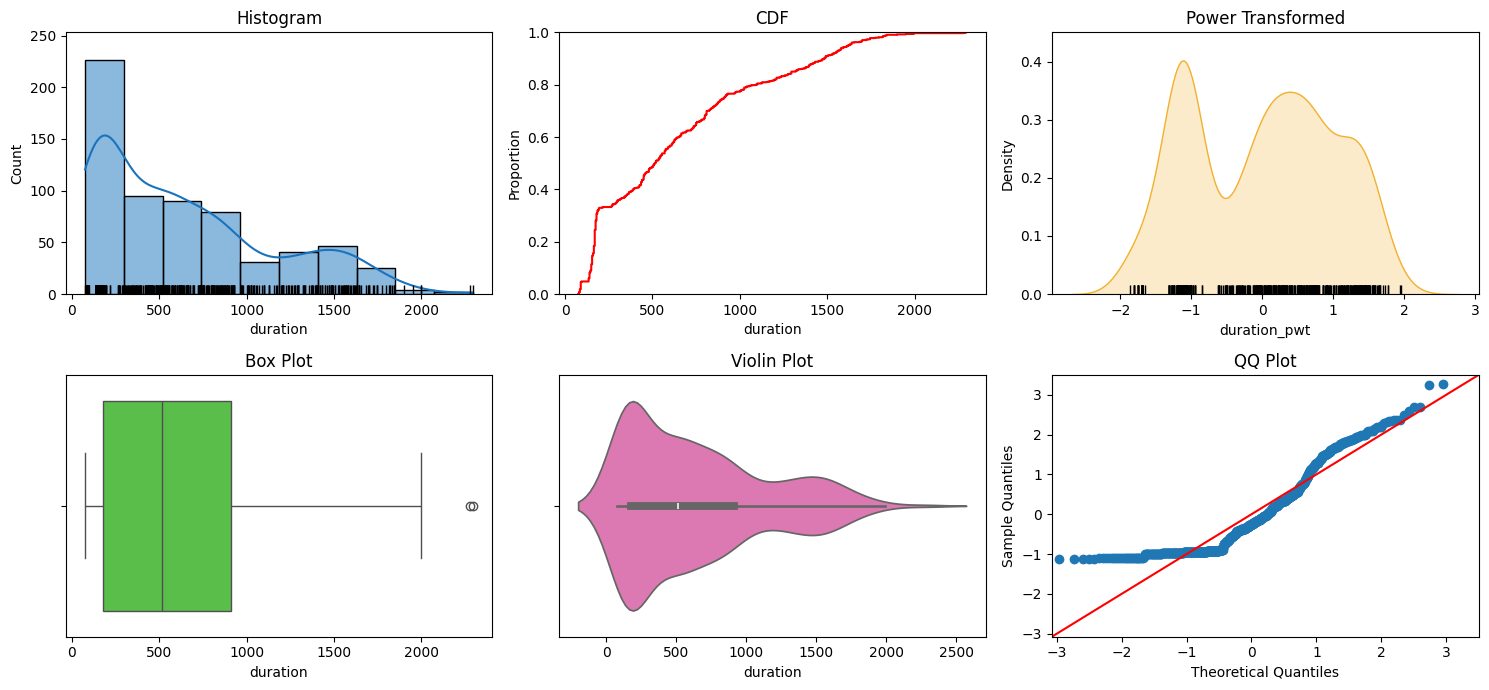

In [46]:
eda_helper_functions.num_univar_plots(train, "duration")

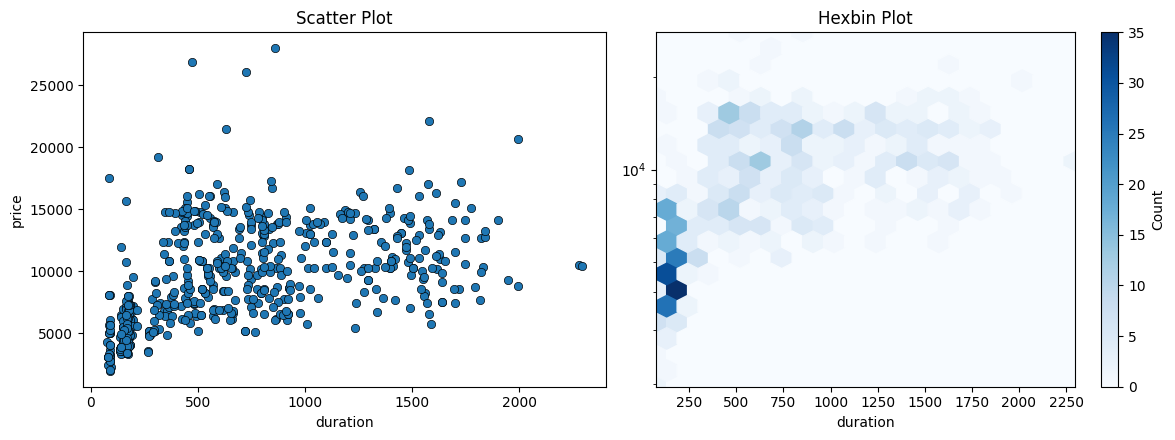

In [47]:
eda_helper_functions.num_bivar_plots(
    train,
    "duration",
    "price",
    hexbin_kwargs=dict(
        yscale="log",
        gridsize=20,
        cmap="Blues"
    )
)

In [48]:
eda_helper_functions.num_num_hyp_testing(train, "price", "duration")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.542657341930945
- p-value              : 2.7434055469618015e-50
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6866006846445073
- p-value              : 2.15818385766989e-90
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


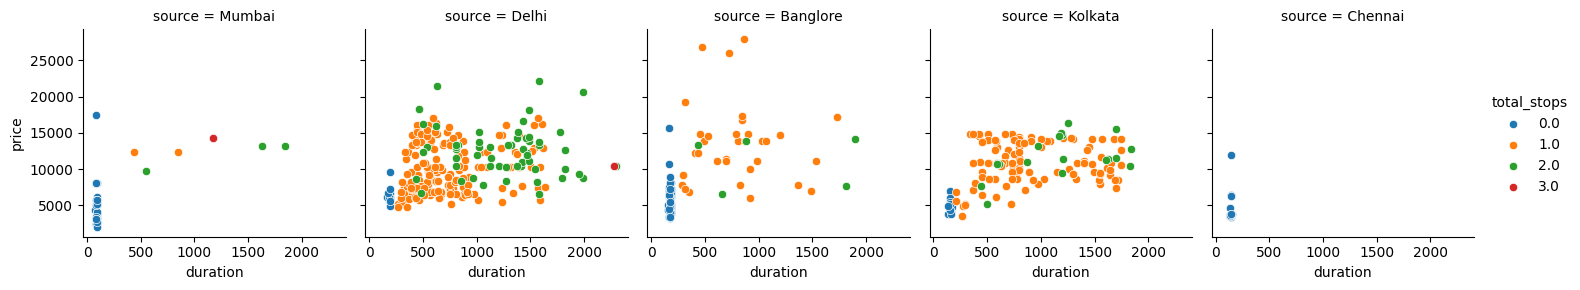

In [49]:
duration_grid = sns.FacetGrid(
    data=train,
    col="source",
    hue="total_stops",
    sharey=True # the y axis is equal for all the plots 
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

### 9. Automated EDA

In [50]:
pip install ydata-profiling

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
from ydata_profiling import ProfileReport

In [52]:
report = ProfileReport(train)

In [53]:
#report.to_file(output_file="output.html")

### Now let's find the outliers in our training data 

In [54]:
eda_helper_functions.get_iqr_outliers(train, "duration")

Lower Limit : -927.5
Upper Limit : 2012.5


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
239,Air India,2019-06-24,Delhi,Cochin,2025-06-01 05:15:00,2025-06-01 19:15:00,2280,3.0,No Info,10493
458,Air India,2019-05-09,Delhi,Cochin,2025-06-01 05:00:00,2025-06-01 19:15:00,2295,2.0,No Info,10441


### Libraries used 
- Pandas 
- Scikit-learn
- Tsfresh
- feature Engine
- NLTK